<a href="https://colab.research.google.com/github/promila3/GoogleCodeJam/blob/master/LSTM_Implementation_for_Bitcoin_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Credit - https://github.com/brynmwangy for code source

#install all the required dependancy libraries
!pip install tensorflow #for prediction
!pip install numpy  #for matrix multiplication
!pip install pandas #define the data structures
!pip install matplotlib #for visualization
!pip install scikit-learn #for normalizing our data(scaling)

#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline


In [0]:
#loading the dataset
from google.colab import files
uploaded = files.upload()

In [0]:
#decoding the files as uploaded will be a dictionary of keys (the file names) and values (the encoded file objects)
btc = pd.read_csv(io.StringIO(uploaded['btc.csv'].decode('utf-8')))
btc.head()

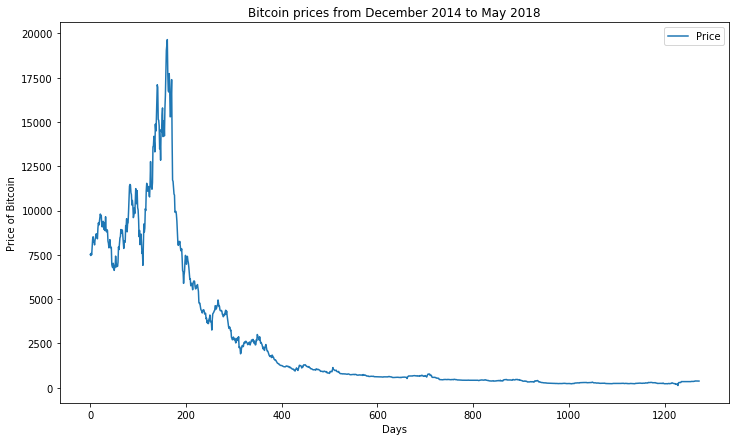

In [0]:
#selecting only the column that we are going to use in the prediction process
data_to_use=btc['Close'].values
data_to_use
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Price of Bitcoin')
plt.plot(data_to_use, label='Price')
plt.legend()
plt.show()

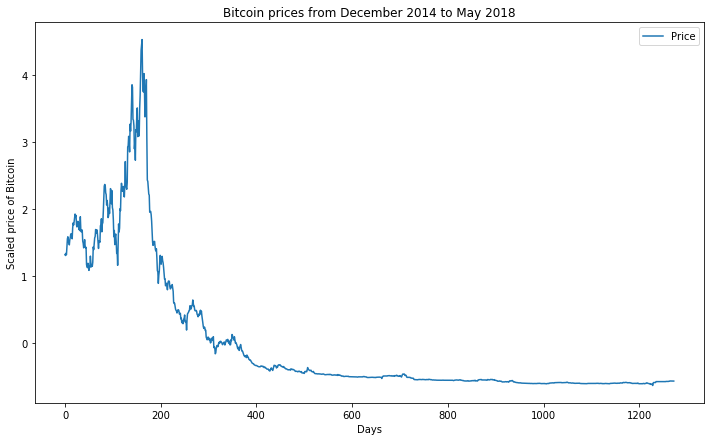

array([[ 1.32443891],
       [ 1.30836052],
       [ 1.34137813],
       ...,
       [-0.56145134],
       [-0.56145134],
       [-0.56356379]])

In [0]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
#plotting the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

scaled_data

In [0]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, 7)


#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

![alt text](https://www.altumintelligence.com/altum-site/altum-intelligence/public/assets/time-series-prediction-using-lstm-deep-neural-networks/lstm_cell.png)

In [0]:
#we now define the network
#Hyperparameters used in the network
batch_size = 7 #how many windows of data we are passing at once
window_size = 7 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 100

import tensorflow as tf
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])



#weights and implementation of LSTM cell
# LSTM weights

#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forget gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
#we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
                
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_4543:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4607:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4671:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4735:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4799:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4863:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4927:0' shape=(1, 1) dtype=float32>]

In [0]:
#we define the loss
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
epochs = 30
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
        print(traind_scores)
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
        
        

In [0]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [0]:
tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)
tests

[[[array([[-0.6251992]], dtype=float32),
   array([[-0.6251655]], dtype=float32),
   array([[-0.62529135]], dtype=float32),
   array([[-0.6252497]], dtype=float32),
   array([[-0.6254097]], dtype=float32),
   array([[-0.62504286]], dtype=float32),
   array([[-0.62504697]], dtype=float32)]],
 [[array([[-0.6250054]], dtype=float32),
   array([[-0.62494296]], dtype=float32),
   array([[-0.62503266]], dtype=float32),
   array([[-0.62501585]], dtype=float32),
   array([[-0.6250325]], dtype=float32),
   array([[-0.62497914]], dtype=float32),
   array([[-0.6249165]], dtype=float32)]],
 [[array([[-0.62486744]], dtype=float32),
   array([[-0.624737]], dtype=float32),
   array([[-0.6247549]], dtype=float32),
   array([[-0.6247744]], dtype=float32),
   array([[-0.62482256]], dtype=float32),
   array([[-0.6248172]], dtype=float32),
   array([[-0.6250782]], dtype=float32)]],
 [[array([[-0.6250649]], dtype=float32),
   array([[-0.6250841]], dtype=float32),
   array([[-0.62505907]], dtype=float32),
 

In [0]:
tests_new = []
for i in range(len(tests)):
  for j in range(len(tests[i][0])):
    tests_new.append(tests[i][0][j])
tests_new)

NameError: ignored

In [0]:

        

    
test_results = []
for i in range(1264):
      if i >= 1019:
        test_results.append(tests_new[i-1019])
      else:
        test_results.append(None)
test_results[1020]


array([[-0.6251655]], dtype=float32)

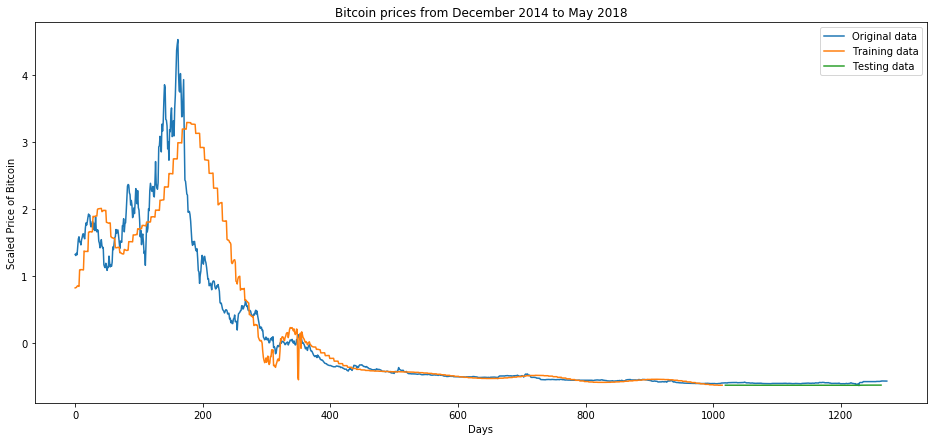

In [0]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()
